In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import sys
import string
import logging
import tempfile
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import ticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import inset_locator
import matplotlib.font_manager as fm
from IPython.display import clear_output

plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams['savefig.dpi'] = 600
plt.rcParams["font.size"] = 18

SAVE_FIGURES = True

if SAVE_FIGURES:
    os.makedirs(os.path.join(os.pardir, "images"), exist_ok=True)
    
sys.path.insert(0, os.pardir)
import squids

In [2]:
import superscreen as sc
sc.version_table()

Software,Version
SuperScreen,0.1.1
Numpy,1.20.3
SciPy,1.6.3
matplotlib,3.4.3
ray,1.4.1
IPython,7.24.1
Python,"3.9.5 (default, May 18 2021, 12:31:01) [Clang 10.0.0 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 2, Logical: 4"
BLAS Info,OPENBLAS


## Spatially inhomogeneous $\Lambda$

### Define the `Device` geometry

In [3]:
import superscreen as sc
from superscreen.geometry import circle, box

length_units = "um"
ro = 3  # outer radius
ri = 1  # inner radius
slit_width = 0.25
layer = sc.Layer("base", Lambda=1.0, z0=0)

ring = circle(ro)
hole = circle(ri)
slit = box(slit_width, 1.5 * (ro - ri), center=(0, -(ro + ri) / 2))

film = sc.Polygon.from_difference([ring, slit, hole], name="ring_with_slit", layer="base")
# # The above is equivalent to all of the following:
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(slit, hole)
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(slit).difference(hole)
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(sc.Polygon(points=hole).union(slit))

film = film.resample(500)
bounding_box = sc.Polygon("bounding_box", layer="base", points=circle(1.2 * ro))

device = sc.Device(
    film.name,
    layers=[layer],
    films=[film],
    abstract_regions=[bounding_box],
    length_units=length_units,
)

### Define a `Parameter` to compute $\Lambda(x, y)$

In [4]:
def linear_vs_angle(
    x: np.ndarray, y: np.ndarray, *, min_val: float, max_val: float
) -> np.ndarray:
    # Rotate the input coordinates so that theta = 0
    # corresponds to the slit position (along the -y axis).
    x, y = sc.geometry.rotate(
        np.stack(np.atleast_1d(x, y), axis=1), np.degrees(-np.pi / 2)
    ).T
    # Calculate the angular position of each mesh vertex.
    angles = np.arctan2(y, x) + np.pi  # range: [0, 2 * pi]
    # Set Lambda to increase linearly from min_val to max_val
    # as a function of angular position.
    Lambdas = angles / (2 * np.pi) * (max_val- min_val) + min_val
    return Lambdas

Lambda = sc.Parameter(linear_vs_angle, min_val=0.1, max_val=1.0)
print(Lambda)

Parameter<linear_vs_angle(min_val=0.1, max_val=1.0)>


### Solve the model

In [5]:
# Assign the Parameter Lambda as the penetration depth of the superconducting layer.
device.layers["base"].Lambda = Lambda
# Generate the mesh and solve.
device.make_mesh(min_points=5_000, optimesh_steps=None)
solution = sc.solve(
    device,
    applied_field=sc.sources.ConstantField(10),
    field_units="uT",
)[-1]

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Finished generating mesh with 4021 points and 7879 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.solve:Calculating base response to applied field.


### Visualize the results

In [6]:
# Sub-figure for Lambda(x, y)
fig_L, ax_L = plt.subplots(figsize=(5, 4))
ax_L.set_aspect("equal")
x, y = device.points.T
triangles = device.triangles
min_Lambda = Lambda.kwargs["min_val"]
max_Lambda = Lambda.kwargs["max_val"]
levels = np.linspace(min_Lambda, max_Lambda, 201)
im = ax_L.tricontourf(x, y, triangles, Lambda(x, y), levels=levels, cmap="bone")
device.films["ring_with_slit"].plot(ax=ax_L, color="C1", lw=3)
cbar = fig_L.colorbar(im, ax=ax_L)
cbar.set_ticks([min_Lambda, max_Lambda])
cbar.set_label("$\\Lambda(x, y)$ [$\\mu$m]", labelpad=-16)
ax_L.axis("off")
scale = 2
um = "$\\mu$m"
scalebar = AnchoredSizeBar(
    transform=ax_L.transData,
    size=scale,
    size_vertical=scale/10,
    loc="lower right",
    label=f"{scale} {um}",
    color="k",
    frameon=False,
    label_top=True,
    pad=-0.5,
    fontproperties=fm.FontProperties(size=20),
)
ax_L.add_artist(scalebar)

# Sub-figure for current density
fig_j, (ax_j, ) = solution.plot_currents(figsize=(5, 4))
ax_j.axis("off")
ax_j.set_title("")

# Sub-figure for magnetic field at z = 0 um
fig_h, (ax_h, ) = solution.plot_fields(figsize=(5, 4))
ax_h.axis("off")
ax_h.set_title("")

# Sub-figure for magnetic field at z = 0.5 um
fig_hf, (ax_hf, ) = solution.plot_field_at_positions(device.points, zs=0.5, figsize=(5, 4))
ax_hf.axis("off")
ax_hf.set_title("")

# Save sub-figures to a temporary directory and load them as images.
with tempfile.TemporaryDirectory() as path:
    fig_L.savefig(os.path.join(path, "Lambda.png"), bbox_inches="tight")
    fig_h.savefig(os.path.join(path, "fields.png"), bbox_inches="tight")
    fig_j.savefig(os.path.join(path, "currents.png"), bbox_inches="tight")
    fig_hf.savefig(os.path.join(path, "fields_at_position.png"), bbox_inches="tight")
    im_L = plt.imread(os.path.join(path, "Lambda.png"))
    im_h = plt.imread(os.path.join(path, "fields.png"))
    im_j = plt.imread(os.path.join(path, "currents.png"))
    im_hf = plt.imread(os.path.join(path, "fields_at_position.png"))

plt.close(fig_L)
plt.close(fig_h)
plt.close(fig_j)
plt.close(fig_hf)

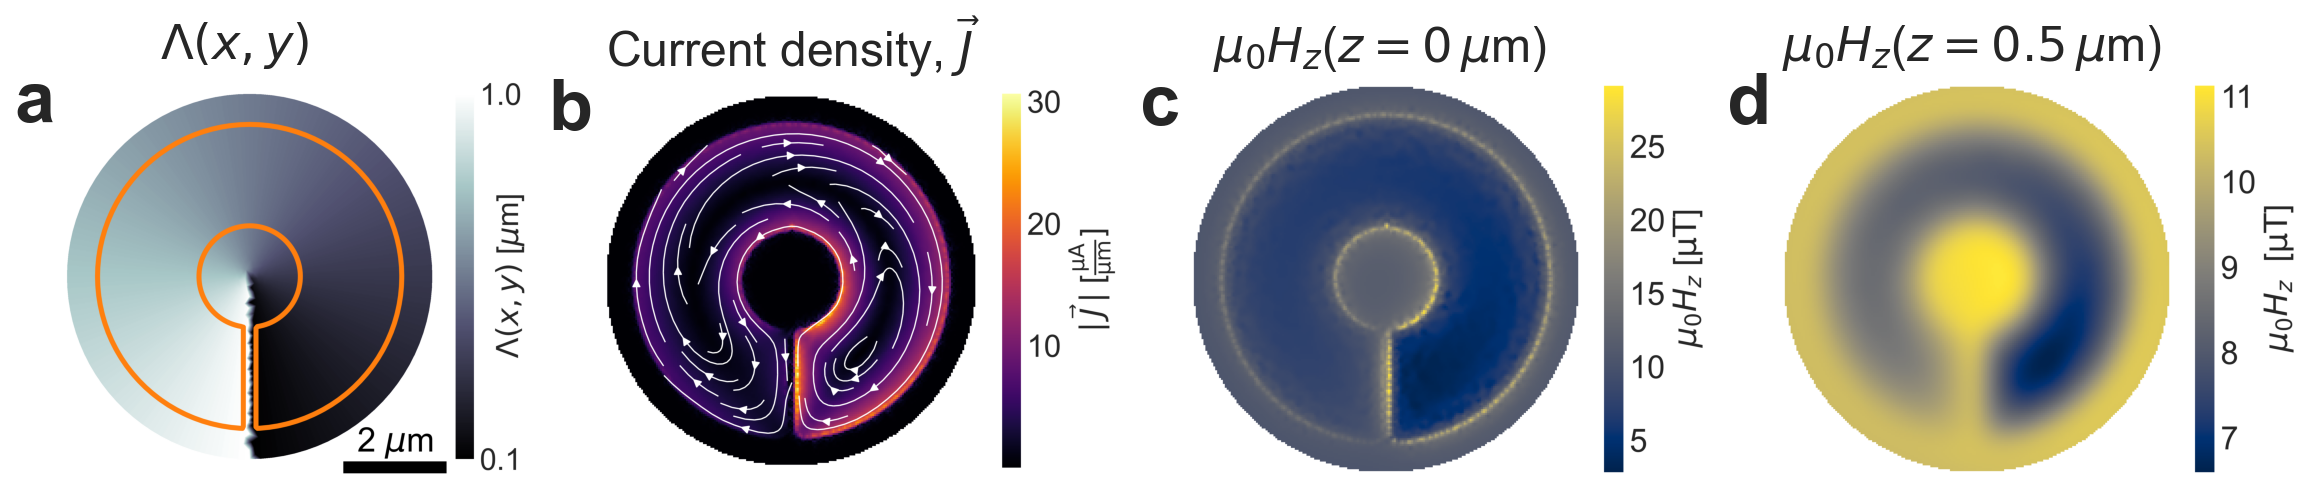

In [7]:
# Populate the full figure with sub-figures
fig, axes = plt.subplots(
    1, 4,
    figsize=(16, 4),
    facecolor="w",
    constrained_layout=True,
    gridspec_kw=dict(width_ratios=[0.9, 1, 1, 1])
)
    
axes[0].imshow(im_L)
axes[1].imshow(im_j)
axes[2].imshow(im_h)
axes[3].imshow(im_hf)

labels = [
    "$\\Lambda(x, y)$",
    "Current density, $\\vec{J}$",
    "$\\mu_0H_z$($z=0\\,\\mu$m)",
    "$\\mu_0H_z$($z=0.5\\,\\mu$m)",
]

for ax, label, title in zip(axes.flat, string.ascii_lowercase, labels):
    ax.set_aspect("equal")
    ax.grid(False)
    ax.axis("off")
    ax.set_title(title, x=0.5 - 0.125, fontsize=24)
    ax.text(0, 1, label, weight="bold", size=36, transform=ax.transAxes, ha="right", va="top")
        
if SAVE_FIGURES:
    fig.savefig("../images/ring_with_slit_inhomogeneous.pdf", bbox_inches="tight")

## Closely-stacked layers, $\delta z<\delta r$

In [8]:
thicknesses = [0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.35, 0.4, 0.45, 0.5]
devices = []
mutuals = []
solutions = []
iterations = 6

I_fc = sc.Device.ureg("1 mA")

for d in thicknesses:
    print(d, flush=True)
    squid = squids.xlarge.make_squid(d_I1=d, d_I2=d)
    squid.solve_dtype = "float32"
    squid.make_mesh(min_points=6_000, optimesh_steps=40)
    devices.append(squid)
    solution = sc.solve(
        squid,
        circulating_currents=dict(fc_center=str(I_fc)),
        iterations=iterations,
        check_inversion=False
    )[-1]
    solutions.append(solution)
    M = sum(solution.hole_fluxoid("pl_center", units="Phi_0")) / I_fc
    mutuals.append(M.to("Phi_0 / A"))
    clear_output(wait=True)

0.5


INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 7841 vertices.
INFO:superscreen.device.device:Finished generating mesh with 7841 points and 15551 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.solve:Calculating W2 response to applied field.
INFO:superscreen.solve:Calculating W1 response to applied field.
INFO:superscreen.solve:Calculating BE response to applied field.
INFO:superscreen.solve:Caching 3 layer-to-layer kernel(s) (704 MB total) in memory.
INFO:superscreen.solve:Calculating W2 response to applied field and screening field from other layers (1/6).
INFO:superscreen.solve:Calculating W1 response to applied field and screening field from other layers (1/6).
INFO:superscreen.solve:Calculating BE response to applied field and screening field from other layers (1/6).
INFO:s

In [9]:
z_BE_W1 = []
z_W1_W2 = []
fc_pl_mutual = []
for sol, mut in zip(solutions, mutuals):
    layers = sol.device.layers
    z_BE_W1.append(layers["BE"].z0 - layers["W1"].z0)
    z_W1_W2.append(layers["W1"].z0 - layers["W2"].z0)
    fc_pl_mutual.append(mut.magnitude)

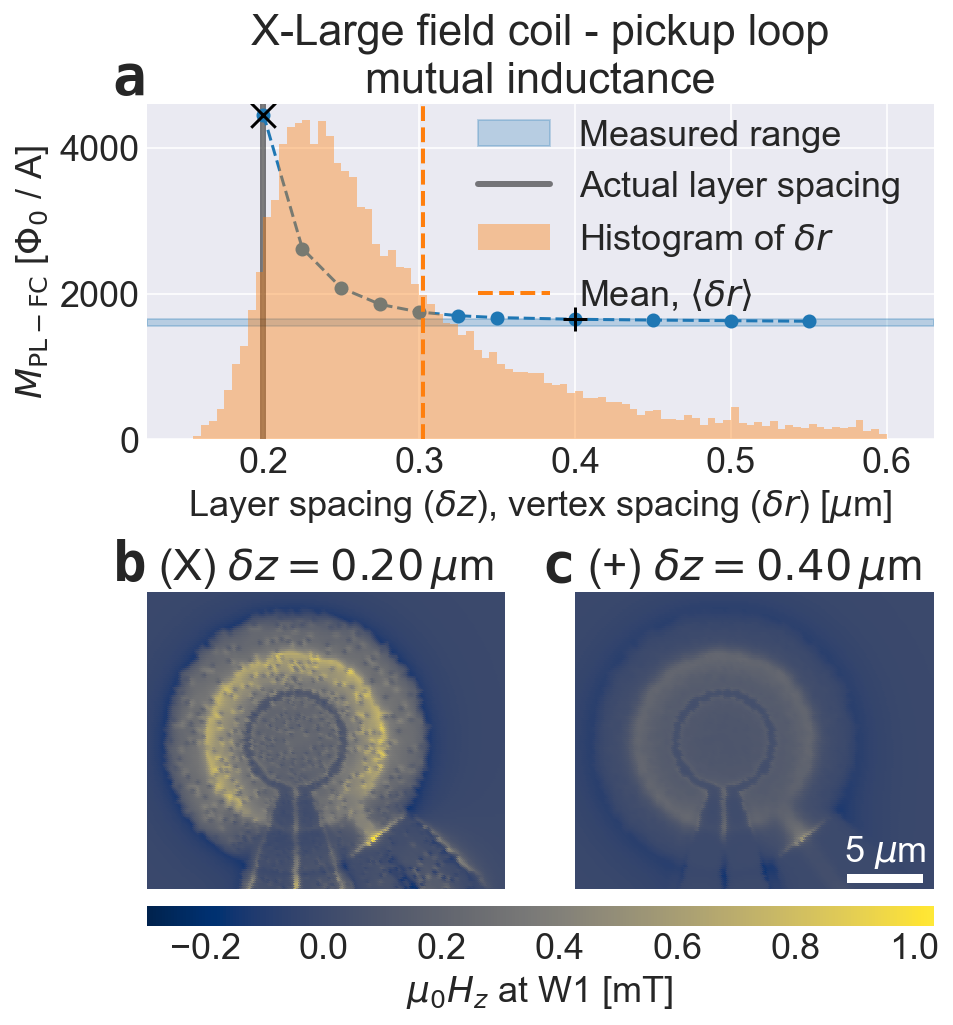

In [10]:
angle = 45

fig = plt.figure(figsize=(6.5, 7), constrained_layout=True)
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, :])
bx, cx = [fig.add_subplot(gs[-1, i]) for i in range(2)]

legend_items = []

patch = ax.axhspan(1598-47, 1598+47, color="C0", alpha=0.25)
legend_items.append((patch, "Measured range"))
xs = z_W1_W2
line = ax.axvline(xs[0], color="k", alpha=0.5, lw=3, label=label)
legend_items.append((line, "Actual layer spacing"))
ax.plot(xs, fc_pl_mutual, "o--")

# dists = vertex_distances(squid.points, squid.triangles)
dists = squid.vertex_distances
ax2 = ax.twinx()
ax2.grid(False)
_, _, (patches, ) = ax2.hist(
    dists,
    bins=np.arange(0, 0.6 + 5e-3, 5e-3),
    density=True,
    histtype="stepfilled",
    color="C1",
    lw=1.5,
    alpha=0.4
)
legend_items.append((patches, "Histogram of $\\delta r$"))
ax2.set_yticks([])
# ax2.set_ylabel("Counts\n(bin size = 50 nm)")

line = ax.axvline(np.mean(dists), color="C1", ls="--", lw=2)
legend_items.append((line, "Mean, $\\langle\\delta r\\rangle$"))

ax.set_xlim(0.125, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])


# ax.set_xlabel("$z_{\\mathrm{BE}-\\mathrm{W1}}$ [$\\mu$m]")
ax.set_xlabel("Layer spacing ($\\delta z$), vertex spacing ($\\delta r$) [$\\mu$m]")
ax.set_ylabel("$M_{\\mathrm{PL}-\\mathrm{FC}}$ [$\\Phi_0$ / A]")
ax.set_title("X-Large field coil - pickup loop\nmutual inductance")
handles, labels = zip(*legend_items)
ax.grid(True)
ax.legend(handles, labels, bbox_to_anchor=(1, 1.05), loc="upper right")


vmin = vmax = None
for index, axes, marker in [(0, bx, "x"), (7, cx, "+")]:
    solution = solutions[index]
    xgrid, ygrid, fields = solution.grid_data("fields", with_units=True)
    w1_field = fields["W1"].to("mT").m
    axes.set_aspect("equal")
    axes.axis("off")
    if vmin is None:
        vmin = w1_field.min()
        vmax = w1_field.max()
    im = axes.pcolormesh(
        xgrid.m, ygrid.m, w1_field,
        shading="auto", cmap="cividis", vmin=vmin, vmax=vmax,
    )
    im.set_edgecolor('face')
    z = xs[index]
    axes.set_title(f"({marker.upper()}) $\\delta z = {{{z:.2f}}}\\,\\mu$m")
    axes.set_ylim(-10, 10)

    ax.scatter(xs[index], fc_pl_mutual[index], marker=marker, fc="k", zorder=12, s=150)
cbar = fig.colorbar(im, ax=[bx, cx], location="bottom", orientation="horizontal", aspect=40)
cbar.set_label("$\\mu_0H_z$ at W1 [mT]")

scale = 5
scalebar_kwargs = dict(
    size=scale,
    loc="lower right",
    label=f"{scale} $\\mu$m",
    frameon=False,
    label_top=True,
    pad=0.1,
    fontproperties=fm.FontProperties(size=18),
)
scalebar = AnchoredSizeBar(
    transform=cx.transData,
    size_vertical=scale / 10,
    color="w",
    **scalebar_kwargs
)
cx.add_artist(scalebar)

for a, s in zip([ax, bx, cx], string.ascii_lowercase):
    a.text(0, 1, s, family="monospace", weight="bold", size=28, transform=a.transAxes, ha="right", va="bottom")

if SAVE_FIGURES:
    fig.savefig("../images/xlarge-dz-dr.pdf", bbox_inches="tight")